# Индексация данных и их связанность в базе данных

План:

* Ограничения
  * Ссылочная целостность
    * Первичный ключ
    * Межтабличные связи
    * Внешний ключ
  * NOT NULL
  * UNIQUE
  * CHECK
* Автоинкременты
* Индексы
* План запроса
* Транзации
* Нормализация отношений
* Правила создания хорошей базы данных
* Демонстрация обеспечения ссылочной целостности данных

## Обновление текущего SQLite 

In [ ]:
 import sqlite3
 sqlite3.sqlite_version

In [ ]:
!curl https://www.sqlite.org/src/tarball/sqlite.tar.gz?r=release | tar xz
%cd sqlite/
!./configure
!make sqlite3.c
%cd /content
!npx degit coleifer/pysqlite3 -f
!cp sqlite/sqlite3.[ch] .
!python setup.py build_static build
!cp build/lib.linux-x86_64-3.7/pysqlite3/_sqlite3.cpython-37m-x86_64-linux-gnu.so \
     /usr/lib/python3.7/lib-dynload/

Затем в меню `Runtime > Restart runtime`. Проверяем:

In [ ]:
import sqlite3
sqlite3.sqlite_version

## Подключаем базу данных в текущую среду

In [ ]:
%load_ext sql
%sql sqlite://

## Ограничения

Обучающий материал и описание взят с [sqlitetutorial.net](https://www.sqlitetutorial.net/sqlite-sample-database/). Все права сохранены за ресурсом.

### Ссылочная целостность

#### [`Первичный ключ`](https://www.sqlitetutorial.net/sqlite-primary-key/)



**Первичный ключ** (primary key) непосредственно применяется для идентификации строк в таблице. Он должен соответствовать следующим ограничениям:

* Первичный ключ должен быть уникальным все время
* Он должен постоянно присутствовать в таблице и иметь значение
* Он не должен часто менять свое значение. В идеале он вообще не должен изменять значение.

Подробнее [здесь](https://metanit.com/sql/tutorial/1.2.php).

SQLite позволяет определять первичный ключ двумя способами:

Во-первых, если первичный ключ содержит только один столбец, вы используете ограничение столбца `PRIMARY KEY` для определения первичного ключа следующим образом:

```sql
CREATE TABLE table_name(
   column_1 INTEGER NOT NULL PRIMARY KEY,
   ...
);
```

Во-вторых, в случае, если первичный ключ состоит из двух или более столбцов, вы используете ограничение таблицы `PRIMARY KEY` для определения первичного ключа, как показано в следующем заявлении.



```sql
CREATE TABLE table_name(
   column_1 INTEGER NOT NULL,
   column_2 INTEGER NOT NULL,
   ...
   PRIMARY KEY(column_1,column_2,...)
);
```

В стандарте SQL столбец первичного ключа не должен содержать нулевых значений. Это означает, что столбец первичного ключа имеет неявное ограничение `NOT NULL`.

Однако, чтобы сделать текущую версию SQLite совместимой с более ранней версией, SQLite позволяет столбцу первичного ключа содержать нулевые значения.

Можно ли добавить первичный ключ через `ALTER TABLE`?



Если вы попытаетесь найти документацию по команде, то ответ на вопрос, по-видимому, это запрещенная информация...

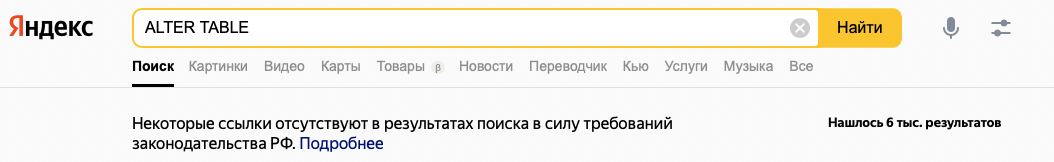

[Официальная документация](https://sqlite.org/faq.html#q11) говорит следующее:


> Если вы хотите внести более сложные изменения в структуру или ограничения таблицы или ее столбцов, вам придется создать ее заново. Вы можете сохранить существующие данные во временной таблице, удалить старую таблицу, создать новую таблицу, а затем скопировать данные обратно из временной таблицы.



Как это делается можно увидеть по [ссылке](https://www.sqlitetutorial.net/sqlite-primary-key/).

Когда вы создаете таблицу без указания параметра без идентификатора строки, SQLite добавляет неявный столбец с именем `rowid`, в котором хранится 64-разрядное целое число со знаком. Столбец `rowid` - это ключ, который однозначно идентифицирует строки в таблице. Таблицы, содержащие столбцы идентификаторов строк, называются таблицами идентификаторов строк.

Следующая инструкция создает таблицу с именем страны, в которой в качестве первичного ключа используется столбец `country_id`:

In [ ]:
%%sql
CREATE TABLE countries (
   country_id INTEGER PRIMARY KEY,
   name TEXT NOT NULL
);

Команда SQLite `PRAGMA` — это специальная команда, которая используется для управления различными переменными среды и флагами состояния в среде SQLite. Значение `PRAGMA` может быть прочитано, и оно также может быть установлено на основе требований.

Подробнее [здесь](https://coderlessons.com/tutorials/bazy-dannykh/vyuchit-sqlite/sqlite-pragma).

In [ ]:
%%sql
pragma table_info('countries');

Можно использовать ограничение таблицы для определения первичного ключа, состоящего из одного столбца, как показано в следующем заявлении:

In [ ]:
%%sql 
CREATE TABLE languages (
   language_id INTEGER,
   name TEXT NOT NULL,
   PRIMARY KEY (language_id)
);

In [ ]:
%%sql
pragma table_info('languages');

Следующая инструкция создает таблицу `country_languages`, первичный ключ которой состоит из двух столбцов.

In [ ]:
%%sql

CREATE TABLE country_languages (
	country_id INTEGER NOT NULL,
	language_id INTEGER NOT NULL,
	PRIMARY KEY (country_id, language_id),
	FOREIGN KEY (country_id) REFERENCES countries (country_id) 
            ON DELETE CASCADE ON UPDATE NO ACTION,
	FOREIGN KEY (language_id) REFERENCES languages (language_id) 
            ON DELETE CASCADE ON UPDATE NO ACTION
);

In [ ]:
%%sql
pragma table_info('country_languages');

#### [Межтабличные связи](https://support.microsoft.com/ru-ru/office/руководство-по-межтабличным-связям-30446197-4fbe-457b-b992-2f6fb812b58f#bm2)

* **Связь "один-ко-многим"**
  
  Рассмотрим базу данных, в которой учитываются заказы, включающую таблицы "Клиенты" и "Заказы" в качестве примера. Клиент может разместить любое количество заказов. Следовательно, у любого клиента, представленного в таблице "Клиенты", может быть много заказов, представленных в таблице "Заказы". Поэтому связь между таблицами "Клиенты" и "Заказы" — это отношение "один-ко-многим".
  
  Чтобы создать отношение "один-ко-многим" в структуре базы данных, добавьте первичный ключ на стороне "один" в таблицу на стороне "многие" в виде дополнительного поля или полей. В данном примере необходимо добавить новое поле — поле "Код" из таблицы "Клиенты" — в таблицу "Заказы" и назвать его "Код клиента". После этого Access сможет использовать номер "Код клиента" из таблицы "Заказы" для поиска клиента каждого заказа.

* **Связь "многие-ко-многим"**
 
  Рассмотрим связь между таблицами "Товары" и "Заказы". Отдельный заказ может включать несколько товаров. С другой стороны, один товар может входить в несколько заказов. Таким образом, для каждой записи в таблице "Заказы" может существовать несколько записей в таблицы "Товары". Таким образом, для каждой записи в таблице "Заказы" может существовать несколько записей в таблице "Заказы". Эта связь называется отношением "многие-ко-многим". Обратите внимание, что для определения существующей схемы отношений "многие ко многим" между вашими таблицами, очень важно рассматривать обе стороны отношений.
  
  Чтобы представить связь "многие-ко-многим", нужно создать третью (связующую) таблицу, в которой она разбивается на две связи "один-ко-многим". Первичные ключи двух таблиц вставляются в третью таблицу. В результате в третьей таблице сохраняются все экземпляры связи. Например, таблицы "Заказы" и "Продукты" имеют связь "многие-ко-многим", определяемую путем создания двух связей "один-ко-многим" в таблице "Заказано". В одном заказе может быть много продуктов, и каждый продукт может быть указан во многих заказах.

* **Связь "один-к-одному"**
  
  При отношении "один-к-одному" каждая запись в первой таблице может иметь не более одной связанной записи во второй таблице, и наоборот. Отношения этого типа используются нечасто, поскольку обычно сведения, связанные таким образом, хранятся в одной таблице. Отношение "один-к-одному" используется для разделения таблицы, содержащей много полей, с целью отделения части таблицы по соображениям безопасности, а также с целью сохранения сведений, относящихся к подмножеству записей в главной таблице. После определения такого отношения у обеих таблиц должно быть общее поле.

#### [`Внешний ключ`](https://www.sqlitetutorial.net/sqlite-primary-key/)

**Внешний ключ** – это ограничение, которое поддерживает согласованное состояние данных между двумя таблицами, обеспечивая так называемую ссылочную целостность.


Давайте начнем с двух таблиц: поставщики и группы поставщиков :

In [ ]:
%%sql
DROP TABLE IF EXISTS suppliers;

CREATE TABLE suppliers (
	supplier_id integer PRIMARY KEY,
	supplier_name text NOT NULL,
	group_id integer NOT NULL
);

DROP TABLE IF EXISTS supplier_groups;

CREATE TABLE supplier_groups (
	group_id integer PRIMARY KEY,
	group_name text NOT NULL
);

Предполагая, что каждый поставщик принадлежит к одной и только одной группе поставщиков. И в каждой группе поставщиков может быть ноль или много поставщиков. Связь между таблицами `supplier_groups` и `suppliers` является отношением "один ко многим". Другими словами, для каждой строки в таблице поставщиков имеется соответствующая строка в таблице `supplier_groups`.

В текущей версии между таблицами `supplier_groups` и `suppliers` не обеспечивается ссылочной целостности.

Чтобы добавить ограничение внешнего ключа в таблицу поставщиков, вы измените определение инструкции `CREATE TABLE` выше следующим образом:

Чтобы проверить, поддерживает ли ваша текущая версия SQLite ограничения внешнего ключа или нет, вы используете следующую команду:

In [ ]:
%%sql
PRAGMA foreign_keys;

Чтобы включить ограничение внешнего ключа:

In [ ]:
%%sql
PRAGMA foreign_keys = ON;

In [ ]:
%%sql
PRAGMA foreign_keys;

In [ ]:
%%sql

DROP TABLE IF EXISTS suppliers;

CREATE TABLE suppliers (
    supplier_id   INTEGER PRIMARY KEY,
    supplier_name TEXT    NOT NULL,
    group_id      INTEGER NOT NULL,
    FOREIGN KEY (group_id) REFERENCES supplier_groups (group_id) 
);


In [ ]:
%%sql
pragma table_info(suppliers)

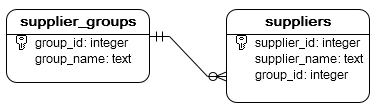

Давайте попробуем вставить три строки в таблицу `supplier_groups`.

In [ ]:
%%sql
INSERT INTO supplier_groups (group_name)
VALUES
   ('Domestic'),
   ('Global'),
   ('One-Time');

Во-вторых, вставим нового поставщика в таблицу поставщиков с группой поставщиков, существующей в таблице `supplier_groups`.

In [ ]:
%%sql

INSERT INTO suppliers (supplier_name, group_id)
VALUES ('HP', 2);

Этот скрипт успешно сработал 😸

Попытаемся вставить нового поставщика в таблицу поставщиков с группой поставщиков, которая не существует в таблице `supplier_groups`.

In [ ]:
%%sql

INSERT INTO suppliers (supplier_name, group_id)
VALUES('ABC Inc.', 4);

In [ ]:
%%sql
SELECT * FROM supplier_groups

In [ ]:
%%sql
SELECT * FROM suppliers

Что произойдет, если вы удалите строку в таблице `supplier_groups`? Должны ли все соответствующие строки в таблице поставщиков также быть удалены? Те же вопросы к операции обновления.

Чтобы указать, как действует ограничение внешнего ключа при удалении или обновлении родительского ключа, используйте действие `ON DELETE` или `ON UPDATE` следующим образом:

```sql
FOREIGN KEY (foreign_key_columns)
   REFERENCES parent_table(parent_key_columns)
      ON UPDATE action 
      ON DELETE action;
```

SQLite supports the following actions:

* SET NULL
* SET DEFAULT
* RESTRICT
* NO ACTION
* CASCADE

На практике значения первичного ключа в родительской таблице не изменяются, поэтому правила обновления менее важны. Более важным правилом является правило `DELETE`, которое определяет действие при удалении родительского ключа.

С примерами можете ознакомится по [ссылке](https://www.sqlitetutorial.net/sqlite-foreign-key/) (примеры удобнее делать в DB Browser for SQLite или в любом другом интерфейсе).

### Ограничение [`NOT NULL`](https://www.sqlitetutorial.net/sqlite-not-null-constraint/)

При создании таблицы вы можете указать, принимает ли столбец нулевые значения или нет. По умолчанию все столбцы таблицы принимают значения `NULL`, за исключением случаев, когда вы явно используете ограничения `NOT NULL`.

Чтобы определить ограничение `NOT NULL` для столбца, вы используете следующий синтаксис:


```sql
CREATE TABLE table_name (
    ...,
    column_name type_name NOT NULL,
    ...
);
```


Примеры использования `NOT NULL` демонстрировались выше в блокноте.

### Ограничение [`UNIQUE`](https://www.sqlitetutorial.net/sqlite-unique-constraint/)

Ограничение `UNIQUE` гарантирует, что все значения в столбце или группе столбцов отличаются друг от друга или уникальны.

Чтобы определить `UNIQUE` ограничение, вы используете ключевое слово `UNIQUE`, за которым следует один или несколько столбцов.

Вы можете определить `UNIQUE` ограничение на уровне столбца или таблицы. Только на уровне таблицы вы можете определить `UNIQUE` ограничение для нескольких столбцов.

Ниже показано, как определить `UNIQUE` ограничение для столбца на уровне столбца:

```sql
CREATE TABLE table_name(
    ...,
    column_name type UNIQUE,
    ...
);
```

Или на уровне таблицы:

```sql
CREATE TABLE table_name(
    ...,
    UNIQUE(column_name)
);
```

Ниже показано, как определить `UNIQUE` ограничение для нескольких столбцов:

```sql
CREATE TABLE table_name(
    ...,
    UNIQUE(column_name1,column_name2,...)
);
```


После определения `UNIQUE` ограничения, если вы попытаетесь вставить или обновить значение, которое уже существует в столбце, SQLite выдаст сообщение об ошибке и прервет операцию.

Следующая инструкция создает новую таблицу с именем контакты с УНИКАЛЬНЫМ ограничением, определенным для столбца электронной почты:

In [ ]:
%%sql
CREATE TABLE contacts(
    contact_id INTEGER PRIMARY KEY,
    first_name TEXT,
    last_name TEXT,
    email TEXT NOT NULL UNIQUE
);

В следующем примере в таблицу контактов вставляется новая строка:

In [ ]:
%%sql
INSERT INTO contacts(first_name,last_name,email)
VALUES ('John','Doe','john.doe@gmail.com');

Если вы попытаетесь вставить новый контакт с тем же адресом электронной почты, вы получите сообщение об ошибке:

In [ ]:
%%sql
INSERT INTO contacts(first_name,last_name,email)
VALUES ('Dan','Pen','john.doe@gmail.com');

SQLite обрабатывает все значения `NULL` по-разному, поэтому столбец с `UNIQUE` ограничением может иметь несколько значений `NULL`.

Следующий оператор создает новую таблицу с именем списки, столбец электронной почты которой имеет `UNIQUE` ограничение:

In [ ]:
%%sql
CREATE TABLE lists(
    list_id INTEGER PRIMARY KEY,
    email TEXT UNIQUE
);

In [ ]:
%%sql
INSERT INTO lists(email)
VALUES(NULL),(NULL);

Как вы можете видеть, несмотря на то, что столбец электронной почты имеет `UNIQUE` ограничение, он может принимать несколько нулевых значений:

In [ ]:
%%sql
SELECT * FROM lists;

### Ограничение [`CHECK`](https://www.sqlitetutorial.net/sqlite-check-constraint/)

Ограничения `CHECK` SQLite позволяют определять выражения для проверки значений всякий раз, когда они вставляются в столбец или обновляются в нем.

Если значения не соответствуют критериям, определенным выражением, SQLite выдаст нарушение ограничений и отменит инструкцию.

В следующем скрипте показано, как определить ограничение `CHECK` на уровне столбца:


```sql
CREATE TABLE table_name(
    ...,
    column_name data_type CHECK(expression),
    ...
);
```

На уровне таблицы:

```sql
CREATE TABLE table_name(
    ...,
    CHECK(expression)
);
```

В этом синтаксисе всякий раз, когда строка вставляется в таблицу или обновляется существующая строка, вычисляется выражение, связанное с каждым ограничением `CHECK`, и возвращается числовое значение `0` или `1`.

Если результат равен нулю, то произошло нарушение ограничений. Если результатом является ненулевое значение или `NULL`, это означает, что нарушения ограничений не произошло.

**Обратите внимание**, что выражение ограничения `CHECK` не может содержать подзапрос.

Следующая инструкция создает новую таблицу с именем контакты:

In [ ]:
%%sql
DROP TABLE IF EXISTS contacts;

CREATE TABLE contacts (
    contact_id INTEGER PRIMARY KEY,
    first_name TEXT    NOT NULL,
    last_name  TEXT    NOT NULL,
    email      TEXT,
    phone      TEXT    NOT NULL
                       CHECK (length(phone) >= 10) 
);

Если вы попытаетесь выполнить следующую инструкцию, вы получите сообщение об ошибке нарушения ограничений:

In [ ]:
%%sql

INSERT INTO contacts (first_name, last_name, phone)
VALUES('John','Doe','408123456');

## Автоинкременты

Ранее мы затрагивали `rowid`. Давайте посмотрим как он будет работать на примере ниже.

Сначала создайте новую таблицу с именем `t1`, содержащую один столбец:

In [ ]:
%%sql
CREATE TABLE t1(c text);

Во-вторых, вставьте несколько строк в таблицу `t1`:

In [ ]:
%%sql
INSERT INTO t1(c) VALUES('A');
INSERT INTO t1(c) values('B');
INSERT INTO t1(c) values('C');
INSERT INTO t1(c) values('D');

В-третьих, запросите данные из таблицы `t1`:

In [ ]:
%%sql
SELECT rowid, c FROM t1;

In [ ]:
%%sql
DELETE FROM t1;

INSERT INTO t1(c) values('E');
INSERT INTO t1(c) values('F');
INSERT INTO t1(c) values('G');

SELECT rowid, c FROM t1;

Как вы можете ясно видеть из выходных данных, SQLite неявно создает столбец с именем `rowid` и автоматически присваивает целочисленное значение всякий раз, когда вы вставляете новую строку в таблицу.

При создании таблицы, которая имеет столбец `INTEGER PRIMARY KEY`, этот столбец является псевдонимом столбца идентификатор строки.


SQLite рекомендует не использовать атрибут `AUTOINCREMENT`, поскольку:

* Ключевое слово `AUTOINCREMENT` накладывает дополнительные затраты на процессор, память, дисковое пространство и дисковый ввод-вывод, и его следует избегать, если в этом нет строгой необходимости. Обычно в этом нет необходимости.
* Кроме того, способ, которым SQLite присваивает значение столбцу `AUTOINCREMENT`, немного отличается от способа, которым он используется для столбца `rowid`.

In [ ]:
%%sql

DROP TABLE IF EXISTS people;

CREATE TABLE people (
   person_id INTEGER PRIMARY KEY AUTOINCREMENT,
   first_name text NOT NULL,
   last_name text NOT NULL
);

In [ ]:
%%sql
DELETE FROM people; 

In [ ]:
%%sql
INSERT INTO people (first_name,last_name)
VALUES ('Johnathan','Smith'),
       ('Dan','Pen');

In [ ]:
%%sql
SELECT rowid, person_id,first_name,last_name FROM people

In [ ]:
%%sql
INSERT INTO people (person_id,first_name,last_name)
VALUES (666, 'Dan','Pen');

Если вы не указываете значение идентификатора строки или используете нулевое значение при вставке новой строки, SQLite автоматически присваивает следующее последовательное целое число, которое на единицу больше, чем самый большой идентификатор строки в таблице. Значение идентификатора строки начинается с 1.

Максимальное значение столбца rowid равно `9,223,372,036,854,775,807`, что очень велико. Если ваши данные достигнут этого максимального значения и вы попытаетесь вставить новую строку, SQLite найдет неиспользуемое целое число и использует его. Если SQLite не может найти какое-либо неиспользуемое целое число, он выдаст ошибку `SQLITE_FULL`. Кроме того, если вы удалите некоторые строки и вставите новую строку, SQLite попытается повторно использовать значения идентификаторов строк из удаленных строк.

Вставим строку с максимальным значением идентификатора строки в таблицу "Люди".

In [ ]:
%%sql
INSERT INTO people (person_id,first_name,last_name)
VALUES(9223372036854775807,'Johnathan','Smith');

In [ ]:
%%sql
INSERT INTO people (first_name,last_name)
VALUES('John','Smith');

Выше возникла [ошибка `database or disk is full`](https://www.sqlite.org/autoinc.html).

## [Индексы](https://www.sqlitetutorial.net/sqlite-index/)

О задаче проектирования индексов [здесь](https://docs.microsoft.com/ru-ru/sql/relational-databases/sql-server-index-design-guide?view=sql-server-ver15).

**Индексы** – это специальные таблицы, которые могут быть использованы поисковым двигателем базы данных, для ускорения получения данных.

В реляционных базах данных таблица представляет собой список строк. В то же время каждая строка имеет ту же структуру столбцов, которая состоит из ячеек. Каждая строка также имеет последовательный порядковый номер `rowid`, используемый для идентификации строки. Таким образом, вы можете рассматривать таблицу как список пар: (`rowid`, `row`).

В отличие от таблицы, индекс имеет противоположное отношение: (`row`, `rowid`). **Индекс** - это дополнительная структура данных, которая помогает повысить производительность запроса.






Каждый индекс должен быть связан с определенной таблицей. Индекс состоит из одного или нескольких столбцов, но все столбцы индекса должны находиться в одной таблице. Таблица может иметь несколько индексов.

Всякий раз, когда вы создаете индекс, SQLite создает структуру B-дерева (по-русски произносится как Би-дерево) для хранения данных индекса.

Индекс содержит данные из столбцов, указанных в индексе, и соответствующее  `rowid`. Это помогает SQLite быстро найти строку на основе значений индексированных столбцов.

Представьте себе индекс в базе данных, как индекс книги. Глядя на индекс, вы можете быстро определить номера страниц на основе ключевых слов.

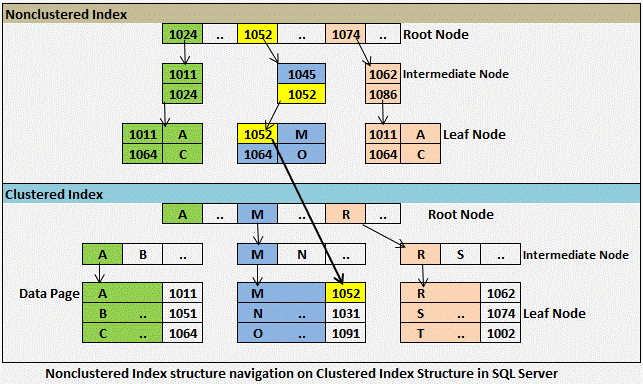

О том, как работает индекс, вы можете ознакомиться [здесь](https://www.sqlitetutorial.net/sqlite-index/).

Полезные ссылки об создании индексов в СУБД: 

* [Би-дерево](https://ru.wikipedia.org/wiki/B-дерево)
* [B+Trees – How SQL Server Indexes are Stored on Disk](https://sqlity.net/en/2445/b-plus-tree/)


Для создания индекса используется инструкция `CREATE INDEX` со следующим синтаксисом:

```sql
CREATE [UNIQUE] INDEX index_name 
ON table_name(column_list);
```

Если вы хотите убедиться, что значения в одном или нескольких столбцах уникальны, например, адрес электронной почты и телефон, вы используете опцию `UNIQUE` в инструкции `CREATE INDEX`. Команда `CREATE UNIQUE INDEX` создает новый уникальный индекс.

Уникальный индекс существует для реализации целостности данных в БД. Как рассказывалось ранее целостность данных может быть гарантирована или `Unique constrain` или `primary key`. В основе обоих лежит **уникальный индекс**.

Подробнее [здесь](https://www.sql.ru/articles/mssql/03013101indexes.shtml#6).



С примерами создания индексов можно ознакомиться [здесь](https://www.sqlitetutorial.net/sqlite-index/).

Получить все индексы из базы данных - выполнить запрос из таблицы `sqlite_master`:

In [ ]:
%%sql
SELECT
   type, 
   name, 
   tbl_name, 
   sql
FROM
   sqlite_master
WHERE
   type= 'index';

Подробнее об индексе через команду `PRAGMA`:

In [ ]:
%%sql
PRAGMA index_info('sqlite_autoindex_country_languages_1');

## План выполнения запроса

**План выполнения запроса** — последовательность операций, необходимых для получения результата SQL-запроса в реляционной СУБД.

План в целом разделяется на две стадии:

* Выборка результатов;
* Сортировка и группировка, выполнение агрегаций.

Сортировка и группировка — это опциональная стадия, которая выполняется, если не найдено путей доступа для получения результата в запрошенном порядке.

Выборка результатов выполняется следующими способами:

* Вложенные циклы;
* Слияние.

Пример плана запроса для [SQL Server](https://www.sql-ex.ru/blogs/?/Vvedenie_v_plan_vypolneniJa_SQL_Server.html).

### Команда [`EXPLAIN QUERY PLAN`](https://www.sqlite.org/eqp.html)

In [ ]:
%%sql
EXPLAIN QUERY PLAN SELECT 1/1;

Загрузка git-репозитория в текущее окружение:

In [ ]:
%cd /content/
!mkdir gitrepos
%cd /content/gitrepos/
!git clone https://github.com/lerocha/chinook-database

Копирование базы данных в папку, в которой будем работать:

In [ ]:
%cd /content/
!mkdir testdata
%cd /content/testdata

In [ ]:
!cp /content/gitrepos/chinook-database/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite  Chinook_Sqlite.sqlite

In [ ]:
%reload_ext sql

%sql sqlite:////content/testdata/Chinook_Sqlite.sqlite

Посмотрим как выполняется запрос на поиск исполнителей, у которых нет альбомов:


In [ ]:
%%sql sqlite:////content/testdata/Chinook_Sqlite.sqlite
EXPLAIN QUERY PLAN 
SELECT
    Name,
    Title
FROM
    artist
LEFT JOIN album ON
    artist.ArtistId = album.ArtistId
WHERE Title IS NULL   
ORDER BY Name
LIMIT 10;

Рассмотрим план выполнения `UNION` команды.

In [ ]:
%%sql sqlite://

DROP TABLE IF EXISTS t1;

CREATE TABLE t1(
    v1 INT
);
 
INSERT INTO t1(v1)
VALUES(1),(2),(3);
 
DROP TABLE IF EXISTS t2;

CREATE TABLE t2(
    v2 INT
);
INSERT INTO t2(v2)
VALUES(2),(3),(4);

In [ ]:
%%sql sqlite://

EXPLAIN QUERY PLAN 
SELECT v1
  FROM t1
UNION
SELECT v2
  FROM t2;

## [Транзакции](https://www.sqlitetutorial.net/sqlite-transaction/)

SQLite - это транзакционная база данных, все изменения и запросы которой являются атомарными, последовательными, изолированными и долговечными (ACID).

[Требования ACID на простом языке](https://habr.com/ru/post/555920/).


По умолчанию SQLite работает в режиме автоматической фиксации. Это означает, что для каждой команды SQLite запускает, обрабатывает и фиксирует транзакцию автоматически.

Чтобы явно начать транзакцию, выполните следующие действия:

Сначала откройте транзакцию, выполнив команду BEGIN TRANSACTION.

```sql
BEGIN TRANSACTION;
```

После выполнения инструкции `BEGIN TRANSACTION` транзакция открыта до тех пор, пока она явно не будет зафиксирована или откатана.

Во-вторых, выполните в SQL-операторы для выбора или обновления данных в базе данных. Обратите внимание, что изменение видно только текущему сеансу (или клиенту).

В-третьих, зафиксируйте изменения в базе данных с помощью инструкции `COMMIT` или `COMMIT TRANSACTION`.

```sql
COMMIT;
```

Если вы не хотите сохранять изменения, вы можете выполнить откат с помощью инструкции по `ROLLBACK` или `ROLLBACK TRANSACTION`:

```sql
ROLLBACK;
```




Пример транзации можно подсмотреть [здесь](https://www.sqlitetutorial.net/sqlite-transaction/). Блокнот транзакции не поддерживает.

Давайте создадим таблицы `accounts` и `account_changes`:


```sql
CREATE TABLE accounts ( 
	account_no INTEGER NOT NULL, 
	balance DECIMAL NOT NULL DEFAULT 0,
	PRIMARY KEY(account_no),
        CHECK(balance >= 0)
);

CREATE TABLE account_changes (
	change_no INT NOT NULL PRIMARY KEY,
	account_no INTEGER NOT NULL, 
	flag TEXT NOT NULL, 
	amount DECIMAL NOT NULL, 
	changed_at TEXT NOT NULL 
);
```

Во-вторых, вставьте некоторые примеры данных в таблицу счетов:

```sql
INSERT INTO accounts (account_no,balance)
VALUES (100,20100);

INSERT INTO accounts (account_no,balance)
VALUES (200,10100);
```

Переведем `1000` со счета `100` на `200` и зарегистрируйте изменения в таблице `account_changes` в одной транзакции.

```sql
BEGIN TRANSACTION;

UPDATE accounts
   SET balance = balance - 1000
 WHERE account_no = 100;

UPDATE accounts
   SET balance = balance + 1000
 WHERE account_no = 200;
 
INSERT INTO account_changes(account_no,flag,amount,changed_at) 
VALUES(100,'-',1000,datetime('now'));

INSERT INTO account_changes(account_no,flag,amount,changed_at) 
VALUES(200,'+',1000,datetime('now'));

COMMIT;
```

## Нормализация отношений



В данном курсе (на момент пилотного запуска программы) нормализация отношений не рассматривается подробно. Эта тема отдается на самостоятельное изучение.

Статьи для изучения:

* [Нормализация отношений. Шесть нормальных форм](https://habr.com/ru/post/254773/)
* [Нормализация баз данных простыми словами](https://info-comp.ru/database-normalization)
* [Описание основных приемов нормализации базы данных](https://docs.microsoft.com/ru-RU/office/troubleshoot/access/database-normalization-description)

## Правила создания хорошей базы данных

Статьи для изучения:

* [Руководство по проектированию реляционных баз данных](https://habr.com/ru/post/193136/)
* [Как спроектировать базу данных, чтобы в будущем не пришлось её переписывать — базовые советы](https://tproger.ru/translations/db-scheme-design-guide/)
* [Основные сведения о создании баз данных](https://support.microsoft.com/ru-ru/office/основные-сведения-о-создании-баз-данных-eb2159cf-1e30-401a-8084-bd4f9c9ca1f5)


## Демонстрация обеспечения ссылочной целостности данных

### Самостоятельная работа

По схеме базы данных, которая готовилась на предыдущей самостоятельной работе, создайте новую базы данных, с учетом первичных и внешних ключей. Также продумайте какие могут быть ограничения для вашей базы данных.